In [1]:
from datetime import datetime
start_time = datetime.now()

# Load libraries
# %pip install keras
# %pip install tensorflow

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

print('LOAD DURATION:',datetime.now() - start_time) # about 3 minutes

LOAD DURATION: 0:00:04.323307


In [2]:
%%time
property_data = pd.read_csv('NY property data.csv')
property_data.head()

CPU times: user 4.15 s, sys: 598 ms, total: 4.75 s
Wall time: 5.52 s


,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


## Filling in missing Zip

In [3]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

29890

In [4]:
for i in range(len(missing_zips)):
    if (property_data.loc[missing_zips[i]+1, 'ZIP'] == property_data.loc[missing_zips[i]-1, 'ZIP']):
        property_data.loc[missing_zips[i], 'ZIP'] = property_data.loc[missing_zips[i]-1, 'ZIP']

In [5]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

16437

In [6]:
for i in range(len(missing_zips)):
    property_data.loc[missing_zips[i], 'ZIP'] = property_data.loc[missing_zips[i]-1, 'ZIP']

In [7]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

0

## STORIES

In [8]:
temp = property_data[property_data['STORIES'].isnull()]
len(temp)

56264

In [9]:
temp['TAXCLASS'].value_counts()

1B    24736
4     22354
3      4635
2      3435
1       897
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [10]:
mean_stories = property_data.groupby('TAXCLASS')['STORIES'].mean()
print(mean_stories)

TAXCLASS
1      2.111641
1A     1.656837
1B     4.000000
1C     3.052748
1D     1.068966
2     16.095110
2A     2.844574
2B     4.004494
2C     4.745097
3      1.333333
4      5.446968
Name: STORIES, dtype: float64


In [11]:
len(property_data[property_data['STORIES']==0])

0

In [12]:
property_data['STORIES'] = property_data['STORIES'].fillna(value=0)
for index in mean_stories.index:
    property_data.loc[(property_data['STORIES']==0)&(property_data['TAXCLASS']==index), 'STORIES']=mean_stories[index]

## Calculate means for AVTOT, AVLAND, FULLVAL by taxclass, avoiding the records with zeros

In [13]:
property_data['FULLVAL'].replace('NaN',0)
temp = property_data[property_data['FULLVAL']!=0]
mean_fullval = temp.groupby('TAXCLASS')['FULLVAL'].mean()
print(mean_fullval)

TAXCLASS
1     5.698435e+05
1A    3.352842e+05
1B    5.613639e+05
1C    7.615359e+05
1D    2.233614e+07
2     7.998018e+05
2A    8.640037e+05
2B    1.252989e+06
2C    7.728799e+05
3     1.112765e+05
4     3.211928e+06
Name: FULLVAL, dtype: float64


In [14]:
property_data['AVLAND'].replace('NaN', 0)
temp_avland = property_data[property_data['AVLAND']!=0]
mean_avland = temp_avland.groupby('TAXCLASS')['AVLAND'].mean()
print(mean_avland)

TAXCLASS
1      14896.433976
1A      2247.369138
1B     14781.268478
1C      8225.658898
1D    709303.793103
2      90830.095031
2A     31363.390619
2B     54446.810503
2C     25639.066531
3      43368.352941
4     600949.433397
Name: AVLAND, dtype: float64


In [15]:
property_data['AVTOT'].replace('NaN', 0)
temp_avtot = property_data[property_data['AVTOT']!=0]
mean_avtot = temp_avtot.groupby('TAXCLASS')['AVTOT'].mean()

print(mean_avtot)

TAXCLASS
1     2.501609e+04
1A    1.436972e+04
1B    1.478410e+04
1C    2.898447e+04
1D    1.166866e+06
2     3.599121e+05
2A    7.961158e+04
2B    1.785982e+05
2C    1.170444e+05
3     5.007444e+04
4     1.488705e+06
Name: AVTOT, dtype: float64


## Substituting decent values for AVTOT, AVLAND, FULLVAL from averages by taxclass

In [16]:
%%time
for index in mean_fullval.index:
    property_data.loc[(property_data['FULLVAL']==0)&(property_data['TAXCLASS']==index), 'FULLVAL'] = mean_fullval[index]
    property_data.loc[(property_data['AVLAND']==0)&(property_data['TAXCLASS']==index), 'AVLAND'] = mean_avland[index]
    property_data.loc[(property_data['AVTOT']==0)&(property_data['TAXCLASS']==index), 'AVTOT'] = mean_avtot[index]

CPU times: user 2.3 s, sys: 48.9 ms, total: 2.35 s
Wall time: 2.29 s


## Fill in LTFRONT, LTDEPTH, BLDDEPTH, BLDFRONT with averages by TAXCLASS

In [17]:
# as these 4 values do not have NAs, we just need to replace 0s
# calculate groupwise average.1st replace 0 and 1 by NAs so they are not counted in calculating mean.

cols = ['LTFRONT', 'LTDEPTH', 'BLDFRONT', 'BLDDEPTH']

for col in cols:
    property_data.loc[property_data[col]==0, col]=np.nan
    property_data.loc[property_data[col]==1, col]=np.nan

In [18]:
# calculate mean now (mean function ignores NAs but not 0s hence we coverted 0 to NA)
mean_LTFRONT = property_data.groupby('TAXCLASS')['LTFRONT'].mean()
mean_LTDEPTH = property_data.groupby('TAXCLASS')['LTDEPTH'].mean()
mean_BLDFRONT = property_data.groupby('TAXCLASS')['BLDFRONT'].mean()
mean_BLDDEPTH = property_data.groupby('TAXCLASS')['BLDDEPTH'].mean()

In [19]:
# impute values

for index in mean_LTFRONT.index:
    property_data.loc[(property_data['LTFRONT'].isnull())&(property_data['TAXCLASS']==index),'LTFRONT'] = mean_LTFRONT[index]
    property_data.loc[(property_data['LTDEPTH'].isnull())&(property_data['TAXCLASS']==index),'LTDEPTH'] = mean_LTDEPTH[index]
    property_data.loc[(property_data['BLDFRONT'].isnull())&(property_data['TAXCLASS']==index),'BLDFRONT'] = mean_BLDFRONT[index]
    property_data.loc[(property_data['BLDDEPTH'].isnull())&(property_data['TAXCLASS']==index),'BLDDEPTH'] = mean_BLDDEPTH[index]

In [20]:
data = property_data.iloc[:,[0]].copy()

data['ZIP'] = property_data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]
data['TAXCLASS'] = property_data['TAXCLASS']
data['B'] = property_data['B']

In [21]:
data['ltsize'] = property_data['LTFRONT'] * property_data['LTDEPTH']
data['bldsize'] = property_data['BLDFRONT'] * property_data['BLDDEPTH']
data['bldvol'] = data['bldsize'] * property_data['STORIES']

data.head()

,RECORD,ZIP,zip3,TAXCLASS,B,ltsize,bldsize,bldvol
0,1,10004.0,100,4,1,523000.000000,5659.149093,3.082520e+04
1,2,10004.0,100,4,1,3614.532322,5659.149093,3.082520e+04
2,3,10004.0,100,4,1,399876.000000,399876.000000,1.199628e+06
3,4,10004.0,100,4,1,436943.000000,46835.000000,9.367000e+04
4,5,10004.0,100,4,1,406980.000000,5073.000000,5.073000e+03


In [22]:
data['r1'] = property_data['FULLVAL'] / data['ltsize']
data['r2'] = property_data['FULLVAL'] / data['bldsize']
data['r3'] = property_data['FULLVAL'] / data['bldvol']
data['r4'] = property_data['AVLAND'] / data['ltsize']
data['r5'] = property_data['AVLAND'] / data['bldsize']
data['r6'] = property_data['AVLAND'] / data['bldvol']
data['r7'] = property_data['AVTOT'] / data['ltsize']
data['r8'] = property_data['AVTOT'] / data['bldsize']
data['r9'] = property_data['AVTOT'] / data['bldvol']

data.head()

,RECORD,ZIP,zip3,TAXCLASS,B,ltsize,bldsize,bldvol,r1,r2,r3,r4,r5,r6,r7,r8,r9
0,1,10004.0,100,4,1,523000.000000,5659.149093,3.082520e+04,40.917782,3781.487225,694.237107,8.079350,746.667022,137.079388,18.413002,1701.669251,312.406698
1,2,10004.0,100,4,1,3614.532322,5659.149093,3.082520e+04,53616.895011,34245.431036,6287.063144,3959.018409,2528.648700,464.230514,24127.602755,15410.443966,2829.178415
2,3,10004.0,100,4,1,399876.000000,399876.000000,1.199628e+06,261.796157,261.796157,87.265386,97.551991,97.551991,32.517330,117.808271,117.808271,39.269424
3,4,10004.0,100,4,1,436943.000000,46835.000000,9.367000e+04,89.714219,836.980890,418.490445,34.913021,325.717946,162.858973,40.371399,376.641401,188.320700
4,5,10004.0,100,4,1,406980.000000,5073.000000,5.073000e+03,669.074647,53676.325646,53676.325646,297.434763,23861.620343,23861.620343,301.083591,24154.346541,24154.346541


In [23]:
ninevars = ['r1','r2','r3','r4','r5','r6','r7','r8','r9']

zip5_med = data.groupby('ZIP')[ninevars].mean()
zip3_med = data.groupby('zip3')[ninevars].mean()
taxclass_med = data.groupby('TAXCLASS')[ninevars].mean()
borough_med = data.groupby('B')[ninevars].mean()

In [24]:
zip5_med.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9
ZIP,,,,,,,,,
10001.0,549.363984,718.715718,139.168312,82.863687,111.651260,27.943118,209.409206,269.742561,48.862604
10002.0,350.833439,533.919942,174.232108,42.887994,89.388921,42.184592,111.591043,179.792640,61.024550
10003.0,586.263725,846.478105,230.800773,44.310823,82.724547,37.126975,131.141632,194.850185,55.669106
10004.0,407.688707,617.730001,153.819187,56.054163,127.029325,55.446690,170.572406,264.536456,66.183915
10005.0,126.448358,169.887110,29.341565,19.723404,31.461622,10.270253,55.427930,74.829566,12.878438


In [25]:
zip3_med.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9
zip3,,,,,,,,,
100,364.834812,561.246883,140.838069,35.184407,65.191091,23.001569,95.178861,147.749020,34.932411
101,355.240500,520.644864,123.542516,25.843011,37.797672,9.438080,76.291176,99.056710,18.631263
102,41.567064,106.831608,5.093253,3.486809,19.531704,0.918801,18.706082,48.076229,2.292332
103,154.291165,467.905539,255.702949,10.640202,22.034075,12.709975,23.293061,35.152971,19.947559
104,134.694489,394.570278,197.213128,5.923620,21.400718,13.486978,15.864774,43.251837,22.513383


In [26]:
taxclass_med.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9
TAXCLASS,,,,,,,,,
1,228.829226,677.973793,328.539508,5.740993,17.609392,8.702869,9.658403,29.462177,14.509626
1A,107.961740,339.058708,260.147936,0.740539,2.284484,1.619291,4.658147,14.567592,10.831783
1B,86.550285,171.924717,42.981389,1.838449,4.526778,1.131702,1.839258,4.527645,1.131919
1C,300.822108,553.263415,204.870892,3.254273,5.946648,2.175123,11.463735,21.040600,7.486923
1D,103.687211,26709.078993,26435.081690,2.556414,774.552451,768.586899,4.622933,1311.888686,1300.929482


In [27]:
borough_med.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9
B,,,,,,,,,
1,355.683369,547.530191,136.667291,33.914229,62.754354,21.822753,92.255104,142.901642,33.360015
2,134.525037,396.040268,197.510632,5.914395,21.541696,13.519786,15.842002,43.988931,22.641767
3,243.927336,584.978370,265.909554,7.645349,20.191244,9.967476,18.374304,41.321633,18.464478
4,168.429915,574.383934,292.739738,6.435159,27.074426,15.009623,13.523576,46.688299,24.319195
5,154.291165,467.905539,255.702949,10.640202,22.034075,12.709975,23.293061,35.152971,19.947559


In [28]:
data.head()

,RECORD,ZIP,zip3,TAXCLASS,B,ltsize,bldsize,bldvol,r1,r2,r3,r4,r5,r6,r7,r8,r9
0,1,10004.0,100,4,1,523000.000000,5659.149093,3.082520e+04,40.917782,3781.487225,694.237107,8.079350,746.667022,137.079388,18.413002,1701.669251,312.406698
1,2,10004.0,100,4,1,3614.532322,5659.149093,3.082520e+04,53616.895011,34245.431036,6287.063144,3959.018409,2528.648700,464.230514,24127.602755,15410.443966,2829.178415
2,3,10004.0,100,4,1,399876.000000,399876.000000,1.199628e+06,261.796157,261.796157,87.265386,97.551991,97.551991,32.517330,117.808271,117.808271,39.269424
3,4,10004.0,100,4,1,436943.000000,46835.000000,9.367000e+04,89.714219,836.980890,418.490445,34.913021,325.717946,162.858973,40.371399,376.641401,188.320700
4,5,10004.0,100,4,1,406980.000000,5073.000000,5.073000e+03,669.074647,53676.325646,53676.325646,297.434763,23861.620343,23861.620343,301.083591,24154.346541,24154.346541


In [29]:
data = data.join(zip5_med, on='ZIP', rsuffix='_zip5')
data = data.join(zip3_med, on='zip3', rsuffix='_zip3')
data = data.join(taxclass_med, on='TAXCLASS', rsuffix='_taxclass')
data = data.join(borough_med, on='B', rsuffix='_boro')

data.head()

,RECORD,ZIP,zip3,TAXCLASS,B,ltsize,bldsize,bldvol,r1,r2,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,1,10004.0,100,4,1,523000.000000,5659.149093,3.082520e+04,40.917782,3781.487225,...,111.778869,355.683369,547.530191,136.667291,33.914229,62.754354,21.822753,92.255104,142.901642,33.360015
1,2,10004.0,100,4,1,3614.532322,5659.149093,3.082520e+04,53616.895011,34245.431036,...,111.778869,355.683369,547.530191,136.667291,33.914229,62.754354,21.822753,92.255104,142.901642,33.360015
2,3,10004.0,100,4,1,399876.000000,399876.000000,1.199628e+06,261.796157,261.796157,...,111.778869,355.683369,547.530191,136.667291,33.914229,62.754354,21.822753,92.255104,142.901642,33.360015
3,4,10004.0,100,4,1,436943.000000,46835.000000,9.367000e+04,89.714219,836.980890,...,111.778869,355.683369,547.530191,136.667291,33.914229,62.754354,21.822753,92.255104,142.901642,33.360015
4,5,10004.0,100,4,1,406980.000000,5073.000000,5.073000e+03,669.074647,53676.325646,...,111.778869,355.683369,547.530191,136.667291,33.914229,62.754354,21.822753,92.255104,142.901642,33.360015


In [30]:
rsuffix = ['_zip5', '_zip3', '_taxclass', '_boro']

for var in ninevars:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

data.head()

,RECORD,ZIP,zip3,TAXCLASS,B,ltsize,bldsize,bldvol,r1,r2,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,1,10004.0,100,4,1,523000.000000,5659.149093,3.082520e+04,40.917782,3781.487225,...,2.794864,0.115040,6.906445,5.079761,0.238229,11.898251,6.281489,0.199588,11.907976,9.364705
1,2,10004.0,100,4,1,3614.532322,5659.149093,3.082520e+04,53616.895011,34245.431036,...,25.310494,150.743329,62.545284,46.002691,116.736206,40.294395,21.272775,261.531359,107.839517,84.807469
2,3,10004.0,100,4,1,399876.000000,399876.000000,1.199628e+06,261.796157,261.796157,...,0.351313,0.736037,0.478140,0.638524,2.876433,1.554506,1.490065,1.276984,0.824401,1.177140
3,4,10004.0,100,4,1,436943.000000,46835.000000,9.367000e+04,89.714219,836.980890,...,1.684761,0.252231,1.528648,3.062111,1.029451,5.190364,7.462806,0.437606,2.635669,5.645102
4,5,10004.0,100,4,1,406980.000000,5073.000000,5.073000e+03,669.074647,53676.325646,...,216.090453,1.881096,98.033545,392.751808,8.770206,380.238484,1093.428521,3.263598,169.027775,724.050838


In [31]:
data1 = data.drop(columns=['ZIP','zip3','TAXCLASS','B','ltsize','bldsize','bldvol'])
data1.head()

,RECORD,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,1,40.917782,3781.487225,694.237107,8.079350,746.667022,137.079388,18.413002,1701.669251,312.406698,...,2.794864,0.115040,6.906445,5.079761,0.238229,11.898251,6.281489,0.199588,11.907976,9.364705
1,2,53616.895011,34245.431036,6287.063144,3959.018409,2528.648700,464.230514,24127.602755,15410.443966,2829.178415,...,25.310494,150.743329,62.545284,46.002691,116.736206,40.294395,21.272775,261.531359,107.839517,84.807469
2,3,261.796157,261.796157,87.265386,97.551991,97.551991,32.517330,117.808271,117.808271,39.269424,...,0.351313,0.736037,0.478140,0.638524,2.876433,1.554506,1.490065,1.276984,0.824401,1.177140
3,4,89.714219,836.980890,418.490445,34.913021,325.717946,162.858973,40.371399,376.641401,188.320700,...,1.684761,0.252231,1.528648,3.062111,1.029451,5.190364,7.462806,0.437606,2.635669,5.645102
4,5,669.074647,53676.325646,53676.325646,297.434763,23861.620343,23861.620343,301.083591,24154.346541,24154.346541,...,216.090453,1.881096,98.033545,392.751808,8.770206,380.238484,1093.428521,3.263598,169.027775,724.050838


In [32]:
summary = data1.describe().T
summary

,count,mean,std,min,25%,50%,75%,max
RECORD,1070994.0,535497.500000,309169.481439,1.000000e+00,267749.250000,535497.500000,803245.750000,1.070994e+06
r1,1070994.0,211.587048,667.298827,3.180786e-04,70.924572,150.384615,241.000000,3.423792e+05
r2,1070994.0,542.508933,2328.098157,7.068200e-04,170.538697,493.333333,680.341880,1.097094e+06
r3,1070994.0,249.084360,1491.143666,8.607173e-05,68.800879,234.895833,333.064516,1.097094e+06
r4,1070994.0,11.034654,178.761499,8.333333e-06,2.230459,4.556098,7.222129,1.540706e+05
r5,1070994.0,28.673038,979.313585,2.008340e-04,5.606622,14.878788,20.293030,4.914844e+05
r6,1070994.0,13.976310,643.995038,1.038033e-05,1.736443,7.083124,10.033206,4.914844e+05
r7,1070994.0,27.211257,268.821110,8.333333e-06,5.128400,8.485584,13.492500,1.540706e+05
r8,1070994.0,56.466939,1285.734106,3.062474e-04,16.717333,26.814732,36.015873,8.249136e+05
r9,1070994.0,23.062487,705.017745,6.049251e-05,6.570424,12.588911,17.567593,4.936922e+05


In [33]:
summary.to_csv('statistics_summary.csv')

In [34]:
data1.to_csv('data1.csv')

In [35]:
df = pd.read_csv('data1.csv')
df = df.iloc[:,1:]

In [36]:
df.head()

,RECORD,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,1,40.917782,3781.487225,694.237107,8.079350,746.667022,137.079388,18.413002,1701.669251,312.406698,...,2.794864,0.115040,6.906445,5.079761,0.238229,11.898251,6.281489,0.199588,11.907976,9.364705
1,2,53616.895011,34245.431036,6287.063144,3959.018409,2528.648700,464.230514,24127.602755,15410.443966,2829.178415,...,25.310494,150.743329,62.545284,46.002691,116.736206,40.294395,21.272775,261.531359,107.839517,84.807469
2,3,261.796157,261.796157,87.265386,97.551991,97.551991,32.517330,117.808271,117.808271,39.269424,...,0.351313,0.736037,0.478140,0.638524,2.876433,1.554506,1.490065,1.276984,0.824401,1.177140
3,4,89.714219,836.980890,418.490445,34.913021,325.717946,162.858973,40.371399,376.641401,188.320700,...,1.684761,0.252231,1.528648,3.062111,1.029451,5.190364,7.462806,0.437606,2.635669,5.645102
4,5,669.074647,53676.325646,53676.325646,297.434763,23861.620343,23861.620343,301.083591,24154.346541,24154.346541,...,216.090453,1.881096,98.033545,392.751808,8.770206,380.238484,1093.428521,3.263598,169.027775,724.050838


In [37]:
# Z scale the variables before PCA

data = df.copy()
data.drop(columns='RECORD', inplace=True)
data_zs = (data-data.mean())/data.std()

(0.0, 1.0)

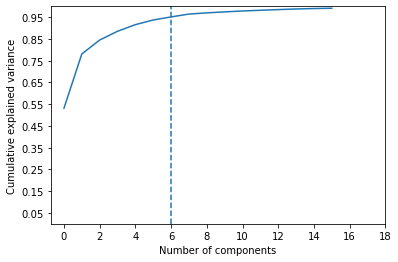

In [38]:
# first, compute most of the PC components and look at the scree plot

from sklearn.decomposition import PCA

pca = PCA(n_components=.99, svd_solver='full')
pca.fit(data_zs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 20, step=2))
plt.axvline(x=6, linestyle='--')
plt.ylim(0, 1)

In [39]:
# Now decide to just keep the top 6 PCs. Recompute them.

pca = PCA(n_components=8)
princ_comps = pca.fit_transform(data_zs)
data_pca = pd.DataFrame(princ_comps, columns=['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1070994, 8)

In [40]:
# Z scale the PC's

pca_mean = data_pca.mean()
pca_sd = data_pca.std()
data_pca = (data_pca-pca_mean) / pca_sd
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
count,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06
mean,5.430648e-16,8.054854e-17,-3.178069e-16,2.333253e-15,4.952349e-15,-3.682394e-16,2.753692e-15,2.309625e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.473123e-01,-3.121770e+02,-4.693497e+02,-1.839580e+02,-3.911585e+02,-2.618056e+02,-2.129463e+02,-2.261011e+02
25%,-6.862403e-02,-9.947863e-02,-6.131603e-02,-1.448078e-01,-1.114987e-01,-7.018110e-02,-1.120012e-01,-5.556639e-02
50%,-1.944495e-02,-4.105365e-02,1.099319e-02,-2.396822e-02,-5.630883e-02,7.528705e-04,4.433172e-03,1.525716e-02
75%,1.192503e-02,2.033200e-02,1.500593e-01,5.505625e-02,3.222940e-02,1.235224e-01,8.384062e-02,1.295484e-01
max,5.229280e+02,6.036698e+02,6.141779e+02,3.898520e+02,4.478940e+02,4.230685e+02,3.327264e+02,3.030399e+02


In [41]:
data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.542193,-0.361890,0.178177,1.103545,-1.023708,-0.629847,1.093366,0.100293
1,14.030730,36.410934,-29.325441,24.314736,44.335876,-14.134824,41.506504,-26.195623
2,-0.017539,0.090764,0.091846,-0.128796,-0.023055,0.055193,-0.144916,0.416165
3,0.135280,-0.184662,0.052796,-0.101049,-0.224712,0.039882,0.031393,0.341238
4,26.227799,-15.458395,-25.729132,-12.964778,-2.185017,6.225251,4.992216,8.609934


In [42]:
# Model 1: z score outliers 
# Here we chose the power in the distance formula to be 2, which is the Euclidean distance
# calculate the distance from origin

p = 3
one_over_p = 1/p
score1 = (((data_pca).abs()**p).sum(axis=1))**one_over_p
score1

0           1.611777
1          64.639817
2           0.429021
3           0.393925
4          34.749764
             ...    
1070989     0.224049
1070990     0.311191
1070991     0.294841
1070992     0.284785
1070993     0.157002
Length: 1070994, dtype: float64

In [43]:
# Model 2: autoencoder error

# !pip install keras
# !pip install tensorflow

In [44]:
from keras.models import Model
from keras.layers import Input, Dense

# placeholder for input
data_in = Input(shape=(8,))

# dimension of the encoded data. Choose 3
encoded_dim = 3

# encoded representation of the data
encoded = Dense(encoded_dim, activation='tanh')(data_in)

# reconstruction of the input
decoded = Dense(8, activation='tanh')(encoded)

# this model maps the input data to the reconstructed data
autoencoder = Model(data_in, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(data_pca, data_pca, epochs=5, shuffle=True, validation_data=(data_pca, data_pca))


Epoch 1/5
33469/33469 [==============================] - 43s 1ms/step - loss: 0.7780 - val_loss: 0.9304
Epoch 2/5
33469/33469 [==============================] - 39s 1ms/step - loss: 0.8723 - val_loss: 0.9283
Epoch 3/5
33469/33469 [==============================] - 45s 1ms/step - loss: 0.9274 - val_loss: 0.9274
Epoch 4/5
33469/33469 [==============================] - 42s 1ms/step - loss: 0.8682 - val_loss: 0.9272
Epoch 5/5
33469/33469 [==============================] - 42s 1ms/step - loss: 0.9589 - val_loss: 0.9262


In [45]:
pca_out = autoencoder.predict(data_pca)
error = pca_out - data_pca

In [46]:
error.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-0.393902,-0.045415,0.063261,-1.034531,0.612127,0.227252,-0.643283,-0.864363
1,-13.039852,-35.411002,28.325444,-23.314789,-43.335885,13.135160,-40.507258,25.376503
2,-0.103897,-0.021276,-0.040302,-0.079855,0.037059,0.094290,0.063677,-0.088590
3,-0.208618,0.079346,0.089401,-0.036272,0.087668,0.040704,-0.081762,-0.297985
4,-25.228316,14.513461,24.729882,13.964778,3.096454,-7.216191,-5.969879,-9.609934


In [47]:
p=3
oop=1/p
score2 = ((error.abs()**p).sum(axis=1))**oop

(0.1, 2141450.516593692)

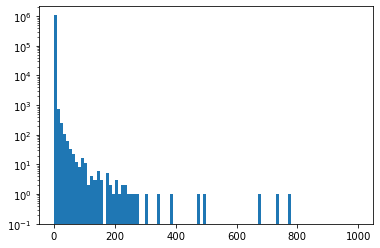

In [48]:
plt.hist(score1, bins=100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

(0.1, 2141891.957945445)

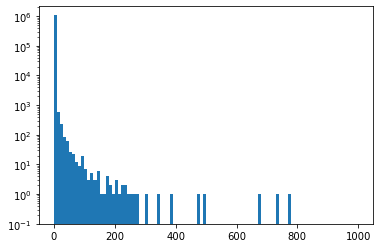

In [49]:
plt.hist(score2, bins=100, range=(0, 1000))
plt.yscale('log')
plt.ylim(ymin=.1)

In [50]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['score1_rank'] = scores['score1'].rank()
scores['score2_rank'] = scores['score2'].rank()
scores['final'] = (scores['score1_rank']+scores['score2_rank'])/2
top_records = scores.sort_values(['final'], ascending=False).head(100).index
top_records

Int64Index([ 917941,  565391,   85885,  684703,   67128,  915468,  690832,
            1059882,   44247,  116646,   39769,     418,  565397,  106680,
             501142,  556608,   33750,  738017,  252833, 1065869,  957063,
             151043,  918203,   48220,  964933,  139725,  918857,  927226,
             104410,  915469,  932860,  985596,   19241,  771149,  752487,
             684562,  610681,  691878,   97083,  330290,  964947,   60468,
             720599,  245572,  934792,  649674,  109066,  556910,  973911,
             248664,   56135,  216947,  665157,  340899,  153069,   85883,
             131602,  177645,  464854,  773561,  991516,  817348,  621688,
             918304,  764311,   47983,  923882,   86945,  994818,  994816,
             994812,  994814,  917059,  638992,  451671,  209711,  209713,
             918204,  994820,  243058,  992070,  991782,  174538,   26242,
             398277,   12075,  918919,  334956,  934749,   56133,     427,
             116645,  773

In [51]:
property_data.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.0,...,64.439787,87.82073,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.0,...,64.439787,87.82073,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709.0,...,709.000000,564.00000,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793.0,...,85.000000,551.00000,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323.0,...,89.000000,57.00000,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


In [52]:
top_100 = property_data.loc[top_records, :]
scores_100 = scores.loc[top_records, ['score1_rank', 'score2_rank', 'final']].values
top_100[['score1_rank', 'score2_rank', 'final']] = scores_100

top_100.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1_rank,score2_rank,final
917941,917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910.0,...,4.501180e+09,1.644454e+09,4.501180e+09,NaN,FINAL,2010/11,AC-TR,1070994.0,1070994.0,1070994.0
565391,565392,3085900700,3,8590,700,NaN,U S GOVERNMENT OWNRD,V9,4,117.0,...,8.484847e+08,8.484847e+08,8.484847e+08,NaN,FINAL,2010/11,AC-TR,1070993.0,1070993.0,1070993.0
85885,85886,1012540010,1,1254,10,NaN,PARKS AND RECREATION,Q1,4,4000.0,...,2.826018e+07,2.813400e+07,2.826018e+07,NaN,FINAL,2010/11,AC-TR,1070992.0,1070992.0,1070992.0
684703,684704,4036590105,4,3659,105,NaN,W RUFERT,V0,1B,2.0,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1070991.0,1070991.0,1070991.0
67128,67129,1011110001,1,1111,1,NaN,CULTURAL AFFAIRS,Q1,4,840.0,...,2.465055e+09,2.371005e+09,2.465055e+09,NaN,FINAL,2010/11,AC-TR,1070990.0,1070990.0,1070990.0


In [53]:
top_100.to_csv('top_100_records_version2.csv', index=False)

<ipython-input-54-263719a009ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_zs_top_n['RECORD'] = (data_zs_top_n.index + 1).astype(int)


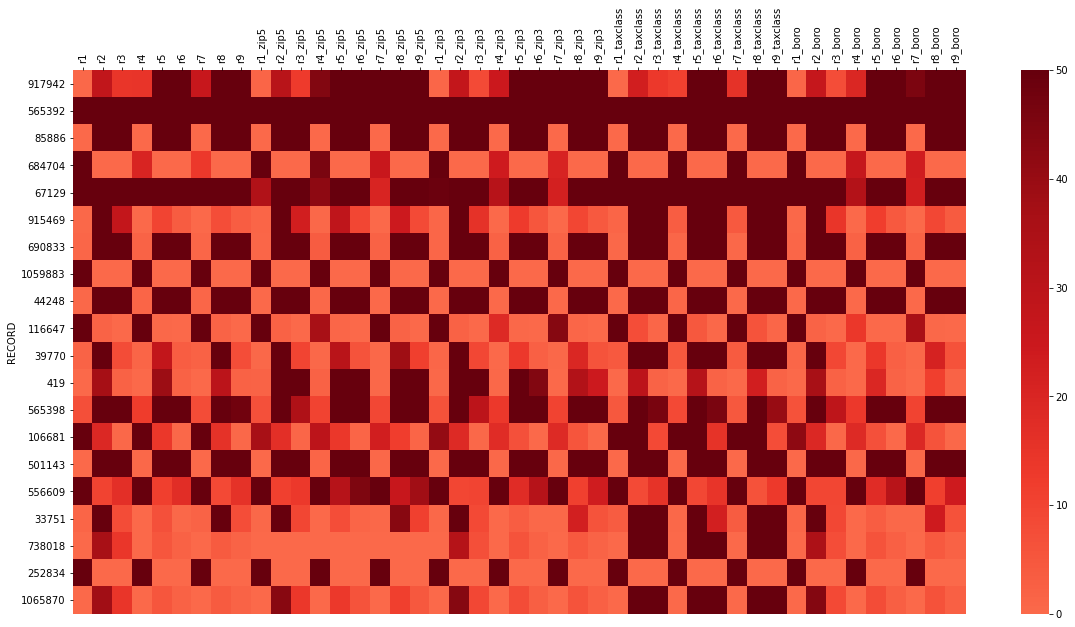

In [54]:
data_zs_top_n = data_zs.iloc[top_records, :]
data_zs_top_n['RECORD'] = (data_zs_top_n.index + 1).astype(int)
data_zs_top_n.set_index('RECORD',inplace=True)

data_zs_top_n_abs = data_zs_top_n.abs()
data_heatmap = data_zs_top_n.abs().head(20)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap_version2.png')

In [55]:
print('Duration: ', datetime.now() - start_time)

Duration:  0:08:56.888174


In [3]:
df_v2 = pd.read_csv('top_100_records_version2.csv')
df_v1 = pd.read_csv('top_100_records.csv')

df_v2.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1_rank,score2_rank,final
0,917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910.0,...,4.501180e+09,1.644454e+09,4.501180e+09,NaN,FINAL,2010/11,AC-TR,1070994.0,1070994.0,1070994.0
1,565392,3085900700,3,8590,700,NaN,U S GOVERNMENT OWNRD,V9,4,117.0,...,8.484847e+08,8.484847e+08,8.484847e+08,NaN,FINAL,2010/11,AC-TR,1070993.0,1070993.0,1070993.0
2,85886,1012540010,1,1254,10,NaN,PARKS AND RECREATION,Q1,4,4000.0,...,2.826018e+07,2.813400e+07,2.826018e+07,NaN,FINAL,2010/11,AC-TR,1070992.0,1070992.0,1070992.0
3,684704,4036590105,4,3659,105,NaN,W RUFERT,V0,1B,2.0,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1070991.0,1070991.0,1070991.0
4,67129,1011110001,1,1111,1,NaN,CULTURAL AFFAIRS,Q1,4,840.0,...,2.465055e+09,2.371005e+09,2.465055e+09,NaN,FINAL,2010/11,AC-TR,1070990.0,1070990.0,1070990.0


In [4]:
df_v1.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1_rank,score2_rank,final
0,917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910.0,...,4.501180e+09,1.644454e+09,4.501180e+09,NaN,FINAL,2010/11,AC-TR,1070994.0,1070994.0,1070994.0
1,565392,3085900700,3,8590,700,NaN,U S GOVERNMENT OWNRD,V9,4,117.0,...,8.484847e+08,8.484847e+08,8.484847e+08,NaN,FINAL,2010/11,AC-TR,1070993.0,1070993.0,1070993.0
2,85886,1012540010,1,1254,10,NaN,PARKS AND RECREATION,Q1,4,4000.0,...,2.826018e+07,2.813400e+07,2.826018e+07,NaN,FINAL,2010/11,AC-TR,1070992.0,1070992.0,1070992.0
3,67129,1011110001,1,1111,1,NaN,CULTURAL AFFAIRS,Q1,4,840.0,...,2.465055e+09,2.371005e+09,2.465055e+09,NaN,FINAL,2010/11,AC-TR,1070991.0,1070991.0,1070991.0
4,684704,4036590105,4,3659,105,NaN,W RUFERT,V0,1B,2.0,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1070990.0,1070990.0,1070990.0


In [11]:
df_v2['RECORD'].isin(df_v1['RECORD']).sum()

93